# AuralSent: Harmonizing Text and Sound for Sentiment Analysis

In [1]:
#!pip install SpeechRecognition
#!pip install librosa

### Data:

https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/datae

In [57]:
import warnings
warnings.filterwarnings ('ignore')

# Import necessary libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# Set style for plotting
plt.style.use('seaborn')
sns.set_style('darkgrid')



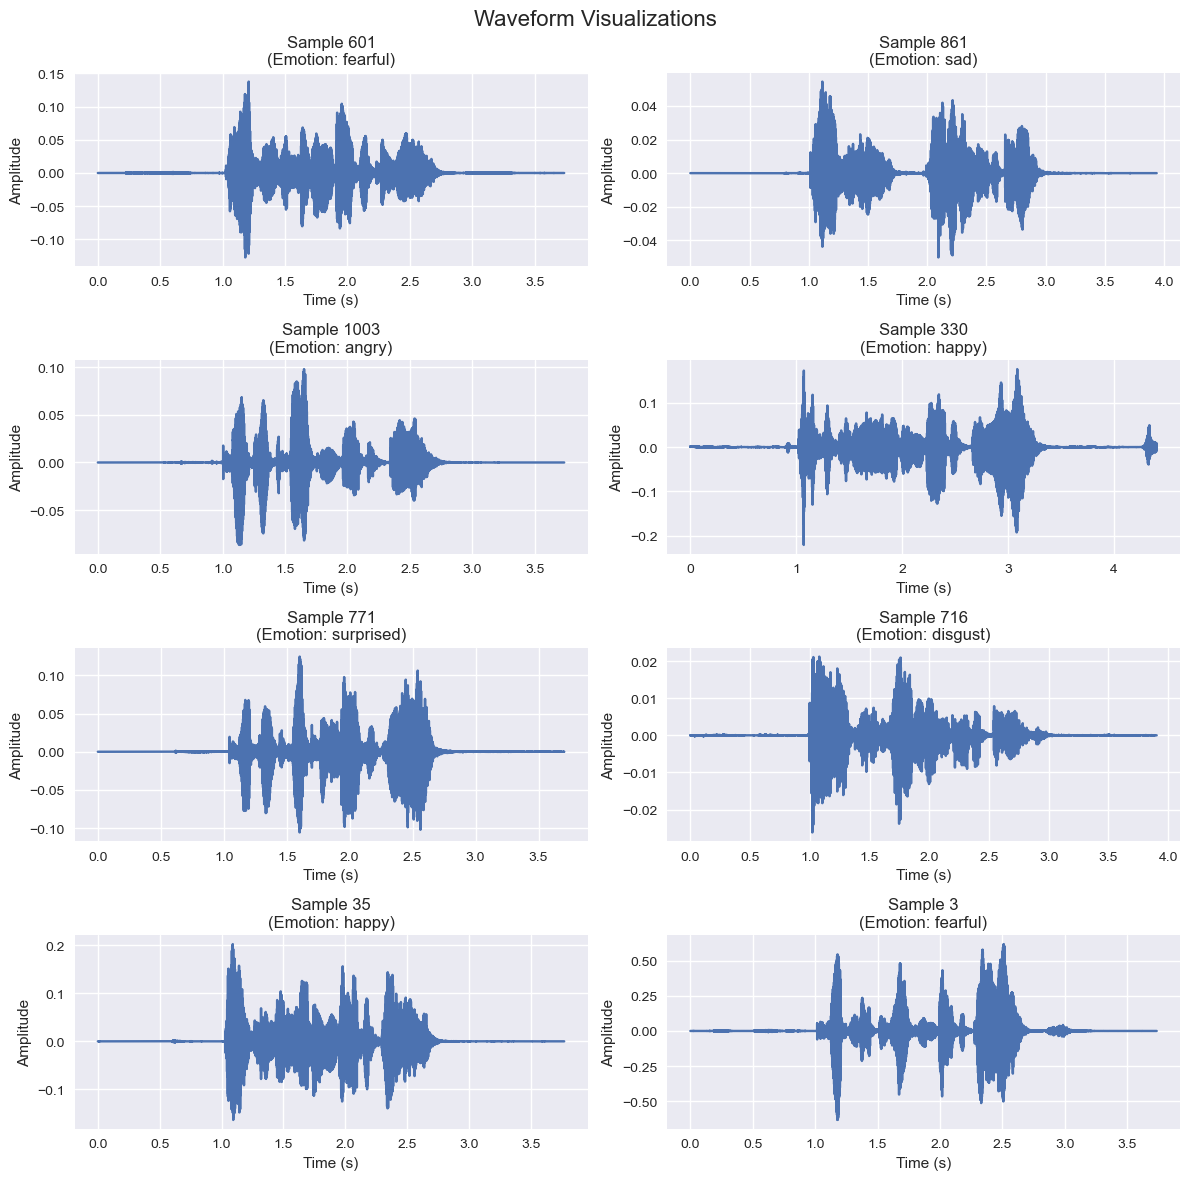

In [17]:
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

speech_data = []  # This will contain file paths
speech_labels = []  # This will contain corresponding labels
dataset_path = 'archive/'

actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
for actor_dir in actor_dirs:
    actor_path = os.path.join(dataset_path, actor_dir)
    filenames = os.listdir(actor_path)
    for filename in filenames:
        speech_data.append(os.path.join(actor_path, filename))
        # Assuming label is the third item in filename split by '-'
        speech_labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

#Random Sample Selection: Choose random samples from your dataset for visualization. 
sample_indices = np.random.choice(len(speech_data), size=8, replace=False)



num_rows = 4
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

fig.suptitle("Waveform Visualizations", fontsize=16)

for i, index in enumerate(sample_indices):
    row = i // num_cols
    col = i % num_cols

    audio_data, sr = librosa.load(speech_data[index])
    label_index = speech_labels[index]
    emotion = emotion_labels[label_index]

    duration = len(audio_data) / sr
    time = np.linspace(0, duration, num=len(audio_data))

    ax = axes[row, col]
    ax.plot(time, audio_data)
    ax.set_title(f"Sample {index+1}\n(Emotion: {emotion})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


## load data

In [26]:
def extract_features_and_labels(dataset_path):
    features, labels = [], []
    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Actors Progress"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            # Extract MFCCs
            y, sr = librosa.load(file_path, sr=None)  # 'sr=None' for the file's original sample rate
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            features.append(mfccs)
            # Extract emotion (3rd item in the filename split by '-')
            labels.append(int(filename.split('-')[2]) - 1)  # Subtract 1 to make labels start from 0
    return np.array(features), to_categorical(np.array(labels))


dataset_path = 'archive/'
features, labels = extract_features_and_labels(dataset_path)

print("Labels_categorical shape:", labels_categorical.shape)


Actors Progress: 100%|██████████████████████████| 24/24 [00:14<00:00,  1.63it/s]

Labels_categorical shape: (1440, 8, 2)


## prep data

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)  # Use labels directly

# Further split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler().fit(X_train)  # Fit on the training data
X_train = scaler.transform(X_train)  # Transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data

# Reshape features for Conv1D input
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (864, 40, 1)
y_train shape: (864, 8)
X_val shape: (288, 40, 1)
y_val shape: (288, 8)
X_test shape: (288, 40, 1)
y_test shape: (288, 8)


## model

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

model = Sequential([
    # Convolutional layers and Max Pooling to extract features
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM layer to learn sequence dependencies
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    
    # Dense layers for prediction
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(len(emotion_labels), activation='softmax')  # Output layer
])

model = Sequential([
    # Convolutional layers and Max Pooling to extract features
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM layer to learn sequence dependencies
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    
    # Dense layers for prediction
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(len(emotion_labels), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10),
]

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 36, 64)            384       
                                                                 
 batch_normalization_24 (Ba  (None, 36, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 18, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 18, 64)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 14, 128)           41088     
                                                                 
 batch_normalization_25 (Ba  (None, 14, 128)          

In [46]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
27/27 [==============================] - 3s 46ms/step - loss: 2.6512 - accuracy: 0.1736 - val_loss: 2.0591 - val_accuracy: 0.2257 - lr: 0.0010
Epoch 2/150
27/27 [==============================] - 1s 23ms/step - loss: 2.3232 - accuracy: 0.2095 - val_loss: 2.0593 - val_accuracy: 0.1840 - lr: 0.0010
Epoch 3/150
27/27 [==============================] - 1s 24ms/step - loss: 2.2104 - accuracy: 0.2222 - val_loss: 2.0502 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 4/150
27/27 [==============================] - 1s 35ms/step - loss: 2.1025 - accuracy: 0.2743 - val_loss: 2.0481 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 5/150
27/27 [==============================] - 1s 32ms/step - loss: 2.0896 - accuracy: 0.2442 - val_loss: 2.0484 - val_accuracy: 0.1424 - lr: 0.0010
Epoch 6/150
27/27 [==============================] - 1s 33ms/step - loss: 1.9659 - accuracy: 0.2859 - val_loss: 2.0681 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 7/150
27/27 [==============================] - 1s 29ms/step - lo

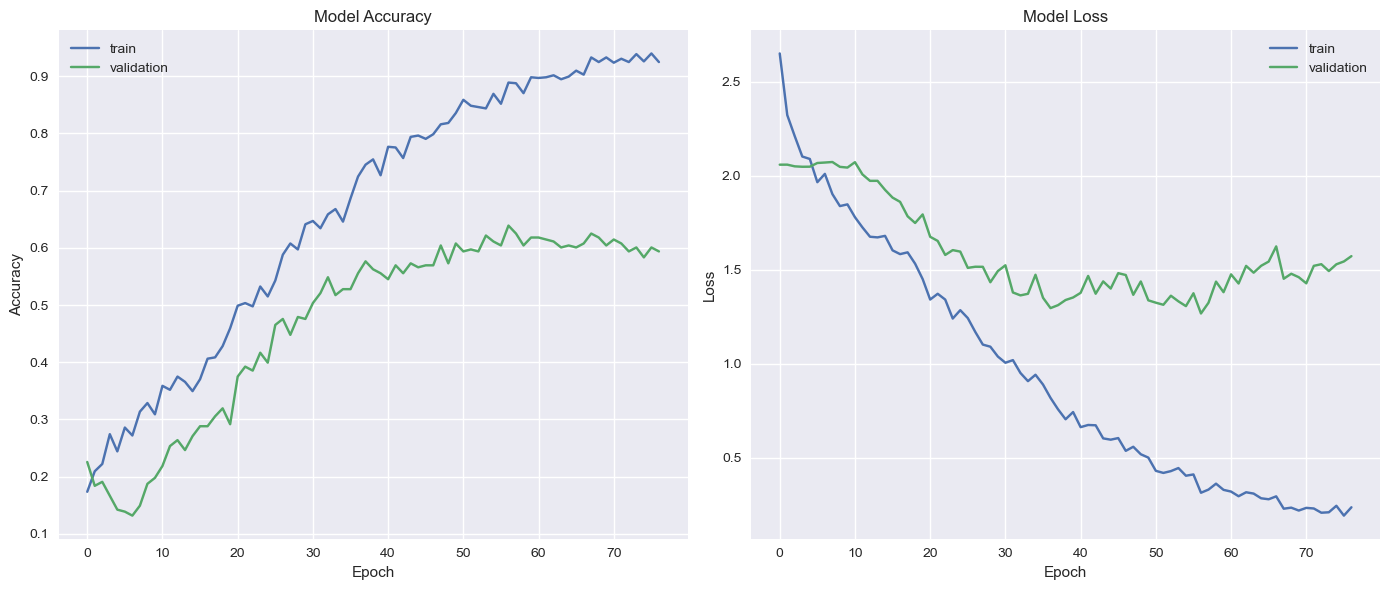

In [47]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='train')
    ax[0].plot(history.history['val_accuracy'], label='validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train')
    ax[1].plot(history.history['val_loss'], label='validation')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


###  Model 2 CCC and Global average pooling

In [59]:
model_cnn_gap = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(emotion_labels), activation='softmax')
])

model_cnn_gap.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn_gap.summary()

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10),
]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 38, 32)            128       
                                                                 
 batch_normalization_35 (Ba  (None, 38, 32)            128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 19, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_27 (Conv1D)          (None, 17, 64)            6208      
                                                                 
 batch_normalization_36 (Ba  (None, 17, 64)            256       
 tchNormalization)                                               
                                                     

In [60]:
history = model_cnn_gap.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

test_loss, test_accuracy = model_bilstm_att.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
27/27 [==============================] - 2s 33ms/step - loss: 2.6360 - accuracy: 0.2002 - val_loss: 2.0589 - val_accuracy: 0.1736 - lr: 0.0010
Epoch 2/150
27/27 [==============================] - 1s 25ms/step - loss: 1.8374 - accuracy: 0.3461 - val_loss: 2.0656 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 3/150
27/27 [==============================] - 1s 24ms/step - loss: 1.5197 - accuracy: 0.4711 - val_loss: 2.0609 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 4/150
27/27 [==============================] - 1s 21ms/step - loss: 1.2467 - accuracy: 0.5683 - val_loss: 2.0723 - val_accuracy: 0.1424 - lr: 0.0010
Epoch 5/150
27/27 [==============================] - 1s 23ms/step - loss: 0.9910 - accuracy: 0.6481 - val_loss: 2.1072 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 6/150
27/27 [==============================] - 1s 23ms/step - loss: 0.8078 - accuracy: 0.7338 - val_loss: 2.0502 - val_accuracy: 0.1806 - lr: 0.0010
Epoch 7/150
27/27 [==============================] - 1s 25ms/step - lo

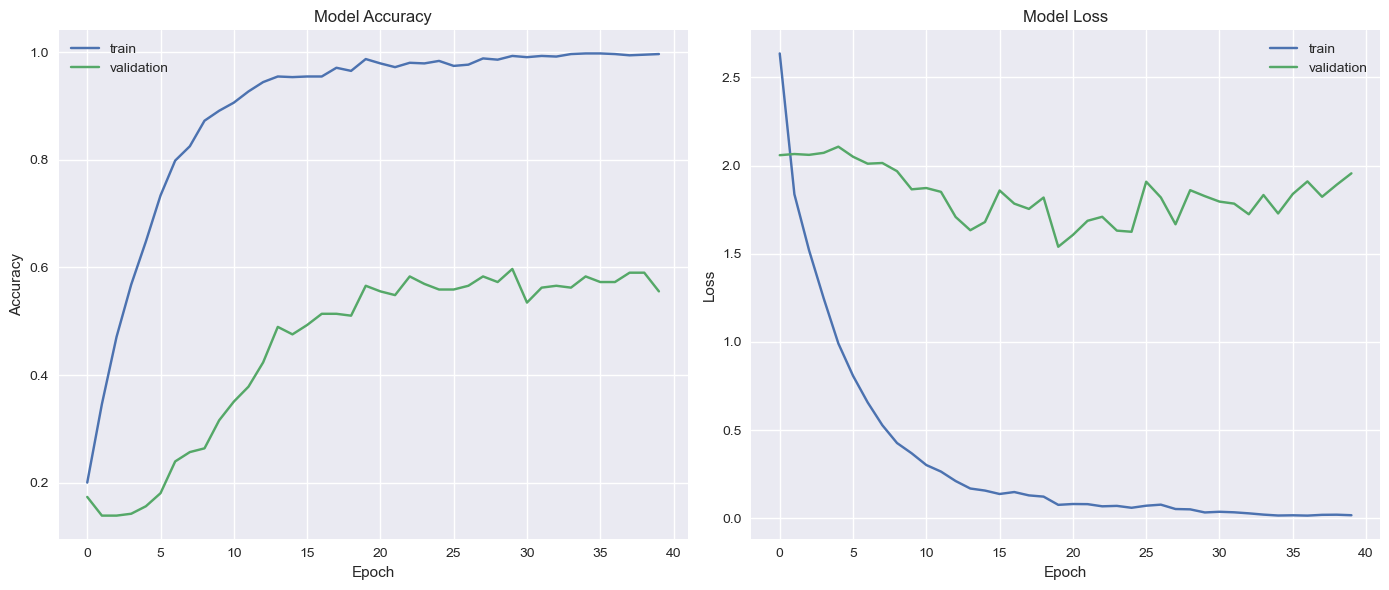

In [61]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='train')
    ax[0].plot(history.history['val_accuracy'], label='validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train')
    ax[1].plot(history.history['val_loss'], label='validation')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


### Model 3: Bidirectional LSTM with Attention Mechanism
This model leverages bidirectional LSTMs to capture temporal dependencies from both directions in the data. An attention mechanism can help the model focus on more relevant parts of the input sequence for making predictions.

In [71]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def get_config(self):
        return super(Attention, self).get_config()


from tensorflow.keras.layers import Bidirectional

model_bilstm_att = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Attention(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(emotion_labels), activation='softmax')
])

model_bilstm_att.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bilstm_att.summary()

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10),
]

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10),
]

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 40, 128)           33792     
 onal)                                                           
                                                                 
 attention_8 (Attention)     (None, 128)               168       
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 8)                 520       
                                                                 
Total params: 42736 (166.94 KB)
Trainable params: 42736 (166.94 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [65]:
history = model_bilstm_att.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

test_loss, test_accuracy = model_bilstm_att.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
27/27 [==============================] - 3s 45ms/step - loss: 2.0740 - accuracy: 0.1505 - val_loss: 2.0594 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 2/150
27/27 [==============================] - 1s 19ms/step - loss: 2.0465 - accuracy: 0.1863 - val_loss: 2.0388 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 3/150
27/27 [==============================] - 0s 18ms/step - loss: 2.0207 - accuracy: 0.2106 - val_loss: 2.0032 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 4/150
27/27 [==============================] - 0s 17ms/step - loss: 1.9942 - accuracy: 0.2222 - val_loss: 1.9757 - val_accuracy: 0.2153 - lr: 0.0010
Epoch 5/150
27/27 [==============================] - 0s 17ms/step - loss: 1.9590 - accuracy: 0.2442 - val_loss: 1.9470 - val_accuracy: 0.2396 - lr: 0.0010
Epoch 6/150
27/27 [==============================] - 1s 29ms/step - loss: 1.9172 - accuracy: 0.2720 - val_loss: 1.9075 - val_accuracy: 0.2535 - lr: 0.0010
Epoch 7/150
27/27 [==============================] - 1s 21ms/step - lo

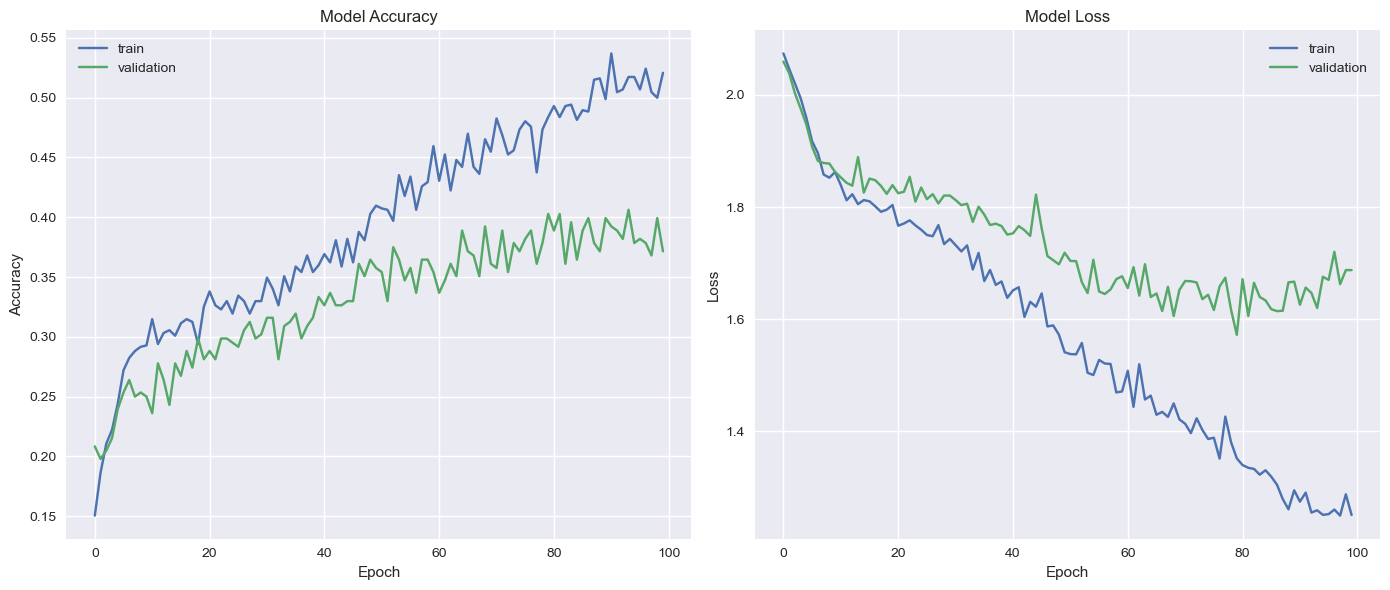

In [66]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='train')
    ax[0].plot(history.history['val_accuracy'], label='validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train')
    ax[1].plot(history.history['val_loss'], label='validation')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


### cobined

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.layers import Layer
import tensorflow.keras.backend as K

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True, regularizer=l2(0.01))
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True, regularizer=l2(0.01))
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Reduced complexity model architecture
reduced_model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Attention(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(len(emotion_labels), activation='softmax')
])

reduced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduced_model.summary()

# Using the same callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001),
]




Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 36, 32)            192       
                                                                 
 batch_normalization_61 (Ba  (None, 36, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_56 (Dropout)        (None, 36, 32)            0         
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_53 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 batch_normalization_62 (Ba  (None, 16, 64)          

In [95]:
# Train the model
history = reduced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = reduced_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
108/108 [==============================] - 5s 25ms/step - loss: 4.0054 - accuracy: 0.2014 - val_loss: 3.2841 - val_accuracy: 0.1840 - lr: 0.0010
Epoch 2/150
108/108 [==============================] - 2s 19ms/step - loss: 2.8145 - accuracy: 0.2616 - val_loss: 2.6823 - val_accuracy: 0.1528 - lr: 0.0010
Epoch 3/150
108/108 [==============================] - 2s 19ms/step - loss: 2.4148 - accuracy: 0.2928 - val_loss: 2.3906 - val_accuracy: 0.2014 - lr: 0.0010
Epoch 4/150
108/108 [==============================] - 2s 19ms/step - loss: 2.2182 - accuracy: 0.2951 - val_loss: 2.2630 - val_accuracy: 0.2118 - lr: 0.0010
Epoch 5/150
108/108 [==============================] - 2s 19ms/step - loss: 2.0979 - accuracy: 0.3009 - val_loss: 2.1365 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 6/150
108/108 [==============================] - 2s 20ms/step - loss: 2.0097 - accuracy: 0.3125 - val_loss: 2.0649 - val_accuracy: 0.2569 - lr: 0.0010
Epoch 7/150
108/108 [==============================] - 2s 

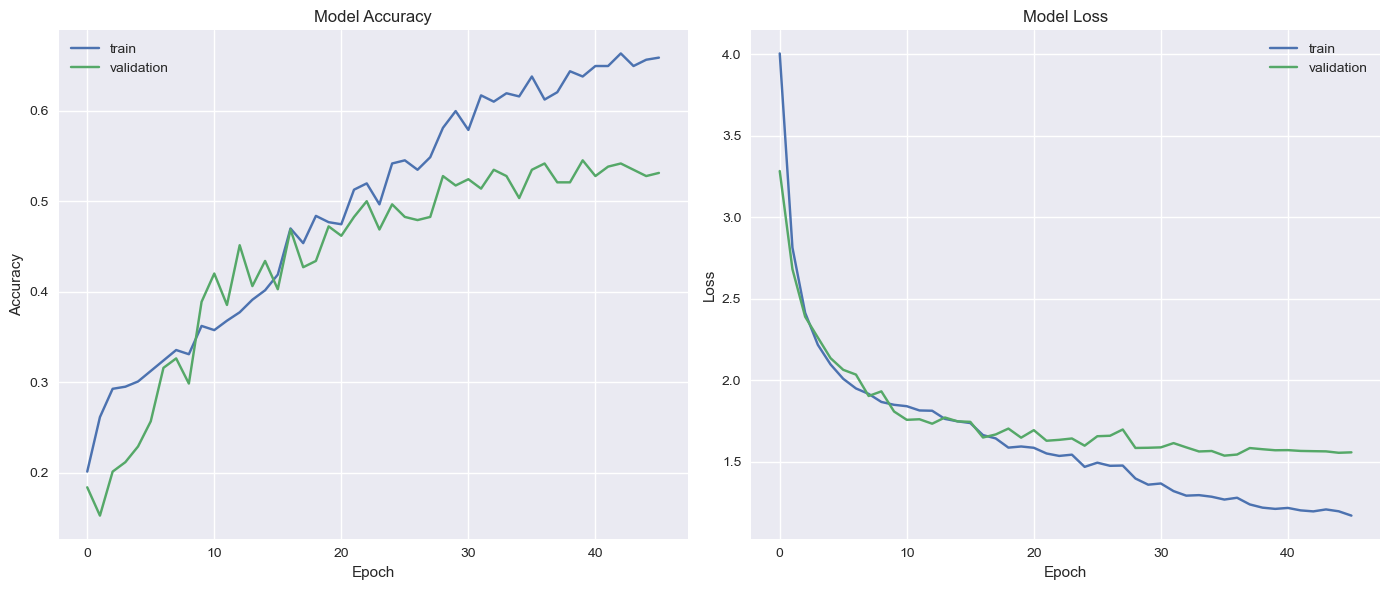

In [96]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='train')
    ax[0].plot(history.history['val_accuracy'], label='validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train')
    ax[1].plot(history.history['val_loss'], label='validation')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

### based on person who did it before. slower and doesnt do much better but also appears not to over fit as much, interesting

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2

model = Sequential()
# LSTM layer with dropout for regularization
model.add(LSTM(128, return_sequences=False, input_shape=(40, 1), dropout=0.2, recurrent_dropout=0.2))
# Dense layer with L2 regularization
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
# Adding dropout for regularization
model.add(Dropout(0.5))
# Another Dense layer with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
# Adding dropout for regularization
model.add(Dropout(0.5))
    # Output layer
model.add(Dense(8))
model.add(Activation('softmax'))
# Configures the model for training
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])


reduced_model.summary()

# Using the same callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001),
]



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 36, 32)            192       
                                                                 
 batch_normalization_61 (Ba  (None, 36, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_56 (Dropout)        (None, 36, 32)            0         
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_53 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 batch_normalization_62 (Ba  (None, 16, 64)          

In [100]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
108/108 [==============================] - 10s 80ms/step - loss: 3.4298 - categorical_accuracy: 0.1447 - val_loss: 2.4067 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/150
108/108 [==============================] - 6s 59ms/step - loss: 2.2539 - categorical_accuracy: 0.2095 - val_loss: 2.0925 - val_categorical_accuracy: 0.1840 - lr: 0.0010
Epoch 3/150
108/108 [==============================] - 5s 49ms/step - loss: 2.0930 - categorical_accuracy: 0.2025 - val_loss: 2.0430 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 4/150
108/108 [==============================] - 6s 54ms/step - loss: 2.0404 - categorical_accuracy: 0.2176 - val_loss: 1.9988 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 5/150
108/108 [==============================] - 6s 56ms/step - loss: 2.0245 - categorical_accuracy: 0.2199 - val_loss: 1.9967 - val_categorical_accuracy: 0.2396 - lr: 0.0010
Epoch 6/150
108/108 [==============================] - 6s 53ms/step - loss: 2.0054 - categoric

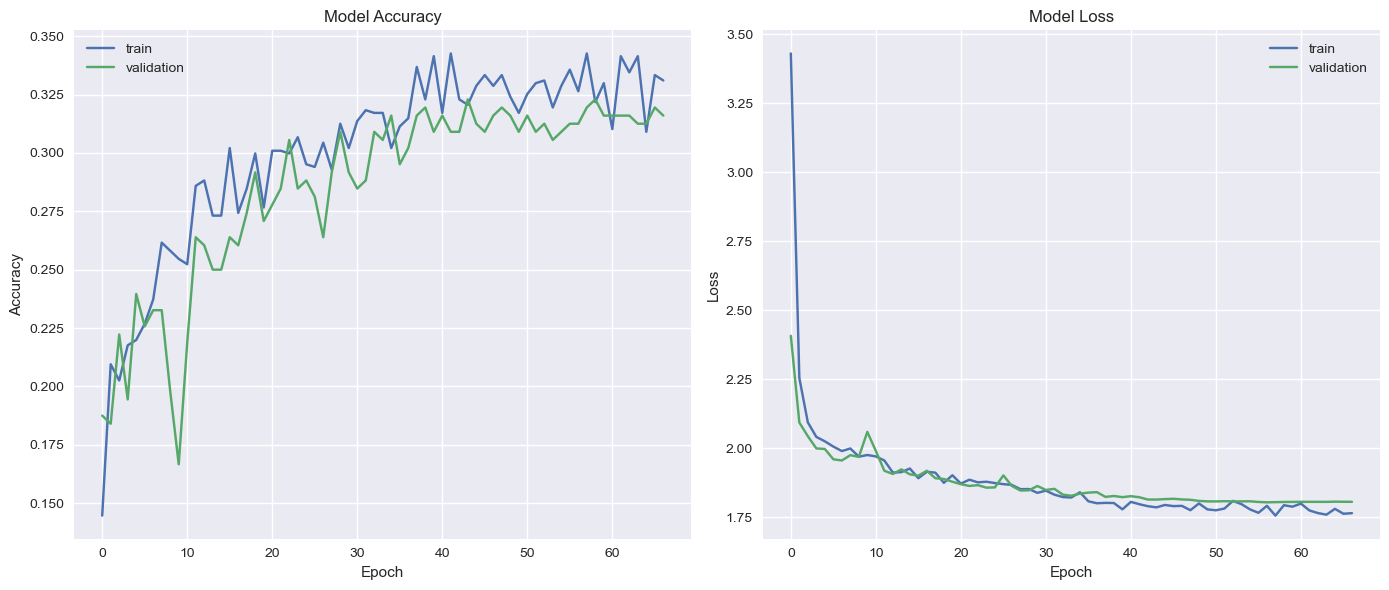

In [104]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot accuracy
    ax[0].plot(history.history['categorical_accuracy'], label='train')
    ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train')
    ax[1].plot(history.history['val_loss'], label='validation')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## transformer

In [130]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, Embedding
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf

def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dropout(rate)(ffn_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

def build_transformer_model(input_shape, num_classes, num_blocks=4, embed_dim=64, num_heads=4, ff_dim=64, rate=0.1):
    inputs = Input(shape=input_shape[1:])
    x = inputs  # Assuming input is already embedding. If not, add an Embedding layer.
    
    for _ in range(num_blocks):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, rate)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(rate)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

# Assuming the shapes and classes from your dataset
num_classes = 8  # Update based on your dataset
input_shape = X_train.shape  # Use the shape of your processed dataset
model = build_transformer_model(input_shape, num_classes)

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 40, 1)]              0         []                            
                                                                                                  
 multi_head_attention_16 (M  (None, 40, 1)                1793      ['input_11[0][0]',            
 ultiHeadAttention)                                                  'input_11[0][0]']            
                                                                                                  
 dropout_105 (Dropout)       (None, 40, 1)                0         ['multi_head_attention_16[0][0
                                                                    ]']                           
                                                                                            

In [131]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=4,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss}")

Epoch 1/150
216/216 [==============================] - 10s 29ms/step - loss: 2.0778 - accuracy: 0.1285 - val_loss: 2.0768 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 2/150
216/216 [==============================] - 6s 27ms/step - loss: 2.0731 - accuracy: 0.1146 - val_loss: 2.0749 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 3/150
216/216 [==============================] - 6s 27ms/step - loss: 2.0701 - accuracy: 0.1169 - val_loss: 2.0738 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 4/150
216/216 [==============================] - 6s 26ms/step - loss: 2.0679 - accuracy: 0.1331 - val_loss: 2.0732 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 5/150
216/216 [==============================] - 7s 34ms/step - loss: 2.0662 - accuracy: 0.1412 - val_loss: 2.0734 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 6/150
216/216 [==============================] - 7s 30ms/step - loss: 2.0651 - accuracy: 0.1412 - val_loss: 2.0731 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 7/150
216/216 [==============================] - 7s

In [75]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        
        LSTM(64),
        Dropout(0.3),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Adjust 'input_shape' and 'num_classes' based on your data
input_shape = (40, 1) # Example input shape, adjust as necessary
num_classes = 8       # Adjust based on your problem

model = create_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# Define callbacks
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
]

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 40, 64)            384       
                                                                 
 batch_normalization_42 (Ba  (None, 40, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 20, 64)            0         
 g1D)                                                            
                                                                 
 dropout_55 (Dropout)        (None, 20, 64)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 20, 128)           24704     
                                                                 
 batch_normalization_43 (Ba  (None, 20, 128)         

In [77]:
# Assuming X_train is your input data and it currently has a shape of (None, 1, 40)
# You need to reshape it to (None, 40, 1)

X_train_reshaped = X_train.reshape((X_train.shape[0], 40, 1))

# Now, X_train_reshaped should have the shape the model expects: (None, 40, 1)

# You can then train your model using X_train_reshaped
history = model.fit(X_train_reshaped, y_train, 
                    epochs=10, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks=callbacks_list, 
                    verbose=2)

Epoch 1/10


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

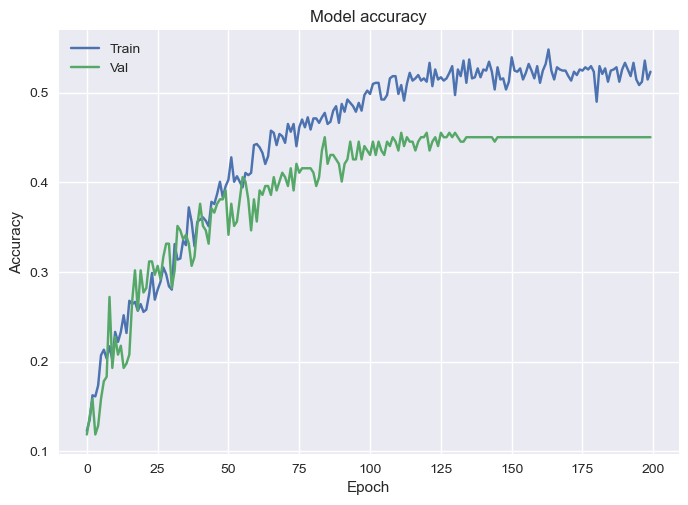

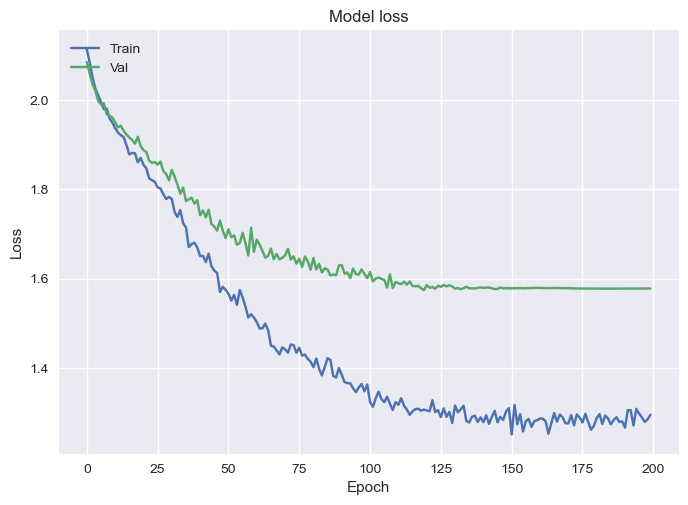

In [66]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


### Preprocessing Acoustic Data
Extract Mel-Frequency Cepstral Coefficients (MFCCs) and other relevant features from audio.

In [16]:
import librosa
import numpy as np

def extract_acoustic_features(audio_path):
    y, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, _ = librosa.piptrack(y=y, sr=sr)
    energy = np.array([
        np.sum(np.abs(y[i:i+512])**2)
        for i in range(0, len(y), 512)
    ])
    return mfccs, pitch, energy


### Text Transcription
Transcribe audio to text using speech recognition.

In [13]:
import speech_recognition as sr

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = ""
    return text


### [TODO] Align Text with Acoustic Features


This step is conceptual as exact alignment depends on the specific requirements and dataset. One approach is to segment audio at natural speech pauses and extract features per segment, aligning them with transcribed text.

### Step 5: Integrate Acoustic Features into Text Representation
Represent acoustic features in a compatible format for T5. This could involve encoding features numerically and appending them to the text or using special tokens.

In [15]:
def integrate_features_with_text(text, features):
    # Example of simple integration; customize based on your approach
    feature_representation = " ".join([str(f) for f in features])
    return f"{text} [FEATURES] {feature_representation}"
